WNixalo | 20181107

---

The best score from this notebook is **0.92255** pvt w/ a threshold of `0.2725`.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

## Data

In [5]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [6]:
df = pd.read_csv(path/'train_v2.csv')

In [7]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [8]:
np.random.seed(0)

In [10]:
src = (ImageFileList.from_folder(path)
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2))

In [11]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

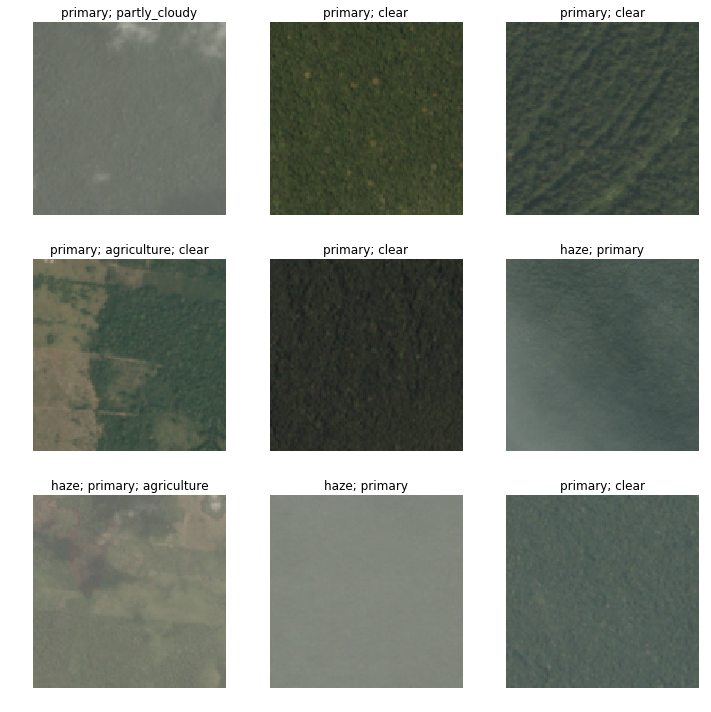

In [14]:
data.show_batch(rows=3, figsize=(10,10))

## MultiClass

I want to see how far I can get with a ResNet34 before going to 50.

In [15]:
arch = models.resnet34

a threshold of 0.25 got me best results last time, so I'll see if putting that will help get more accurate metrics.

In [16]:
f_score = partial(fbeta, thresh=0.25)
learn = create_cnn(data, arch, metrics=[accuracy_thresh, f_score])

### Stage 1 size 128

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


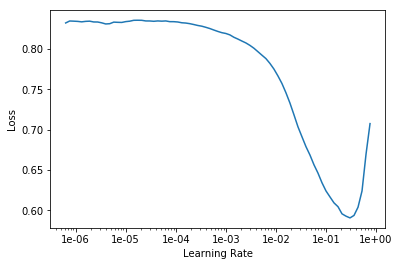

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = 0.01

In [19]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:42
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.119597    0.108920    0.959118         0.902575  (00:56)
2      0.112882    0.104561    0.960731         0.904586  (00:56)
3      0.101292    0.093070    0.964466         0.918754  (00:56)
4      0.098278    0.088706    0.965926         0.921413  (00:56)
5      0.092771    0.088727    0.965767         0.920746  (00:56)



In [20]:
learn.save('stage-1-rn34')

In [23]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:43
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.097067    0.093641    0.964255         0.915009  (00:56)
2      0.103129    0.097543    0.962308         0.912351  (00:56)
3      0.101314    0.092230    0.964844         0.916132  (00:57)
4      0.093662    0.088396    0.966145         0.922029  (00:56)
5      0.088629    0.086680    0.966551         0.923407  (00:56)



In [24]:
learn.save('stage-1-rn34')

### Stage 2 size 128

In [25]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


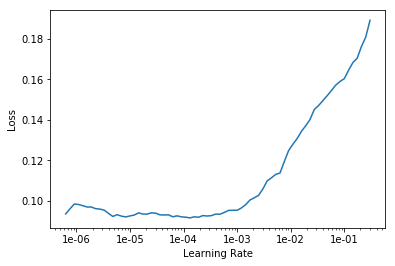

In [26]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:35
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.093670    0.089508    0.965905         0.920727  (01:18)
2      0.096565    0.090523    0.964859         0.918871  (01:19)
3      0.092139    0.087245    0.966428         0.922411  (01:19)
4      0.089290    0.085312    0.967460         0.923503  (01:19)
5      0.084849    0.084243    0.967525         0.925148  (01:19)



In [33]:
learn.save('stage-2-rn34')

In [34]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:36
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.088408    0.087694    0.966661         0.924086  (01:18)
2      0.090188    0.088250    0.966261         0.923865  (01:19)
3      0.088800    0.086665    0.966813         0.922774  (01:19)
4      0.082327    0.084203    0.967620         0.926360  (01:20)
5      0.080077    0.083492    0.967903         0.927219  (01:19)



In [35]:
learn.save('stage-2-rn34')

### Stage 1 size 256

In [37]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [38]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


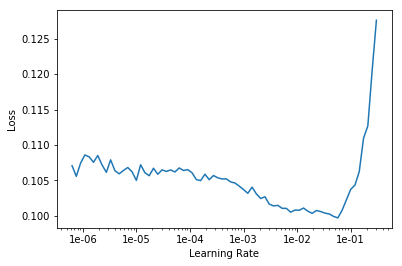

In [39]:
learn.lr_find()
learn.recorder.plot()

In [44]:
lr = 1e-2/2

In [47]:
learn.fit_one_cycle(5, slice(lr))

Total time: 15:08
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.086507    0.086663    0.967191         0.922864  (03:02)
2      0.085802    0.086215    0.966871         0.919749  (03:01)
3      0.086394    0.083083    0.967678         0.927154  (03:01)
4      0.081468    0.082618    0.968419         0.927649  (03:01)
5      0.082359    0.081646    0.968368         0.928802  (03:01)



In [50]:
learn.save('stage-1-256-rn34')

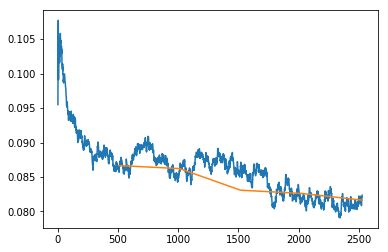

In [49]:
learn.recorder.plot_losses()

In [62]:
learn.fit_one_cycle(5, slice(lr))

Total time: 15:05
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.082235    0.084202    0.967969         0.927815  (02:59)
2      0.084948    0.085538    0.967453         0.921107  (03:01)
3      0.085087    0.083294    0.967969         0.924995  (03:01)
4      0.080113    0.081891    0.968463         0.928349  (03:01)
5      0.081531    0.081528    0.968782         0.928098  (03:01)



In [63]:
learn.save('stage-1-256-rn34')

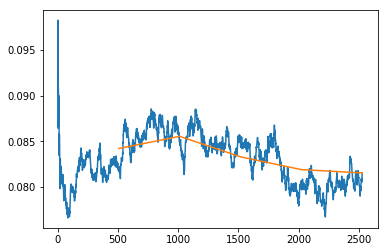

In [74]:
learn.recorder.plot_losses()

### Stage 2 size 256

In [73]:
learn.unfreeze()

In [75]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 20:24
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.084942    0.083557    0.968092         0.924594  (04:03)
2      0.085334    0.083544    0.967816         0.927077  (04:05)
3      0.084125    0.082135    0.968056         0.928769  (04:05)
4      0.079009    0.081487    0.968957         0.928213  (04:04)
5      0.077864    0.081128    0.969233         0.928949  (04:05)



In [76]:
learn.save('stage-2-256-rn34')

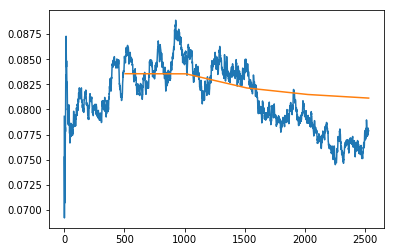

In [77]:
learn.recorder.plot_losses()

**NOTE** Discriminative Learning rates: fast.ai Lesson 2 [1:24:01](https://www.youtube.com/watch?v=BWWm4AzsdLk&feature=youtu.be&t=5038)
- slice: python keyword. evenly distributes vals from start up to stop.
- Stage 2: `max_lr` slice: 1st val from LR Finder well before loss deteriorates; 2nd val abt 10x less than Stage 1 LR.

In [78]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 20:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.081866    0.082985    0.968201         0.926360  (04:03)
2      0.083139    0.084468    0.967649         0.924002  (04:04)
3      0.079232    0.081883    0.968550         0.928960  (04:04)
4      0.075944    0.081376    0.968797         0.928102  (04:04)
5      0.074217    0.081142    0.969001         0.929976  (04:05)



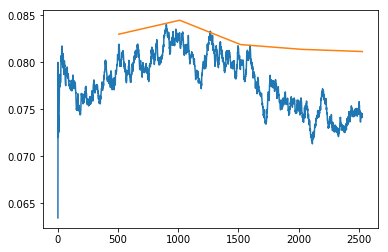

In [79]:
learn.recorder.plot_losses()

In [80]:
learn.save('stage-2-256-rn34_1')

## Test set

In [200]:
# learn.load('stage-2-256-rn34_1') # extra training
learn.load('stage-2-256-rn34')

In [201]:
idx2class = idx2class = {v:k for k,v in learn.data.train_ds.ds.class2idx.items()}

In [202]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [203]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .datasets(ImageMultiDataset)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st dataset portion

In [204]:
set_test_datafolder(learn, 'test-jpg')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:08



In [205]:
len(raw_preds), raw_preds[0].shape, raw_preds[1].shape

(2, torch.Size([40669, 17]), torch.Size([40669, 17]))

In [206]:
preds = copy(raw_preds)

In [207]:
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.ds.x]

2nd dataset portion

In [208]:
set_test_datafolder(learn, 'test-jpg-additional')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:18



In [209]:
preds = (torch.cat((preds[0],raw_preds[0])), torch.cat((preds[1],raw_preds[1])))

In [141]:
# # NOTE: this will work:
# preds = [torch.cat((preds[i],raw_preds[i])) for i in range(len(preds))]

# # but this will leave you with a <generator object <genexpr> at 0x7f91696821a8>
# preds = (torch.cat((preds[i],raw_preds[i])) for i in range(2))

In [210]:
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.ds.x])

## Submitting predictions to Kaggle

In [187]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [215]:
th = 0.3

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [216]:
sub_name = f'planet_stage-2-256-rn34_{date}_th{str(th)}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "fastai 1.0; 2-stg; RN34; threshold="{th}

100%|██████████████████████████████████████| 2.07M/2.07M [00:00<00:00, 2.54MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

'stage-2-256-rn34_1'|threshold|pvt score|rank|'stage-2-256-rn34'|pvt score|rank
-|-|-|-|-|-|-|-|-
#|0.5|0.89458|-|#|0.89430|-
#|0.4|0.91274|-|#|-|-
#|0.3|0.92177|-|#|0.92046|-
#|0.2|0.91901|-|#|-|-
#|0.25|0.92250|-|#|-|-
#|0.2725|0.92255|-|#|0.92201|-

I may go to resnet50.

### Aside:

I don't know how to interpret the 2nd array of `learn.TTA()`'s output,since it's the same for all inputs, independent of output probability. It's supposed to be the actual label I think; so then it's just a dummy value, but then again: why are the first 2 tensors '1' and the rest '0'?

In [173]:
prob = preds[0][1]
pred = preds[1][1]

In [174]:
for i in zip(prob, pred): print(i)

(tensor(0.0011), tensor(1.))
(tensor(0.9985), tensor(1.))
(tensor(0.9008), tensor(0.))
(tensor(0.0104), tensor(0.))
(tensor(0.1569), tensor(0.))
(tensor(0.0143), tensor(0.))
(tensor(0.7164), tensor(0.))
(tensor(0.2470), tensor(0.))
(tensor(0.0010), tensor(0.))
(tensor(0.0005), tensor(0.))
(tensor(0.9845), tensor(0.))
(tensor(0.0083), tensor(0.))
(tensor(0.0002), tensor(0.))
(tensor(0.0001), tensor(0.))
(tensor(0.0004), tensor(0.))
(tensor(0.0002), tensor(0.))
(tensor(0.0001), tensor(0.))


In [178]:
temp = []

In [179]:
for i in range(len(preds[1])):
    for j in range(len(preds[1][i])):
        if preds[1][i][j]==1: temp.append(j)

In [181]:
np.unique(np.array(temp))

array([0, 1])

## end